In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import keras
from keras.models import Model
from keras import Input
from keras.layers import Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate, BatchNormalization
from keras.initializers import he_normal
from keras.optimizers import Adam
from keras import backend as K
from readers import *
import seaborn as sns

2023-12-20 20:15:58.767867: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-20 20:15:58.794056: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-20 20:15:58.794082: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-20 20:15:58.794810: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-20 20:15:58.799361: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# tf.config.experimental.list_physical_devices('GPU')

In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

2023-12-20 20:15:59.995576: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-20 20:16:00.021902: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-20 20:16:00.022048: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [4]:
#from tensorflow.keras import layers
from keras import layers

def build_unet(input_shape):
    inputs = layers.Input(shape=input_shape)

    x = keras.layers.Rescaling(1./255)(inputs)

    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    # x = layers.MaxPooling2D((2, 2), padding='same')(c1)

    #x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    #x = layers.MaxPooling2D((2, 2), padding='same')(x)

    # c2 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    # x = layers.MaxPooling2D((2, 2), padding='same')(c2)
    # x = layers.Dropout(0.5)(x)

    #x = layers.UpSampling2D((2, 2))(x)
    #x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(con_2)
    # con_2 = layers.concatenate([x, c2])
    # 
    # x = layers.UpSampling2D((2, 2))(x)
    # con = layers.concatenate([x, c1])
    # x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(con)
    
    # x = layers.UpSampling2D((2, 2))(x)
    # #con = layers.concatenate([x, c1])
    # x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)


    outputs = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    return keras.Model(inputs, outputs)

# os tamanhos precisam ser multiplos de 2^4
model = build_unet((528, 736, 1)) #(528, 736, 1)

2023-12-20 20:16:00.042523: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-20 20:16:00.042673: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-20 20:16:00.042740: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [5]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 528, 736, 1)]     0         
                                                                 
 rescaling (Rescaling)       (None, 528, 736, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 528, 736, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 528, 736, 1)       577       
                                                                 
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [6]:
# training, target = generate_dataset(qtd_max=100)
training, target = load_generated_data()

In [7]:
target = target.astype('float16')
training = training.astype('float16')

In [8]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true) # GT
    y_pred_f = K.flatten(y_pred) # Predicted
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (K.sum(y_true_f*y_true_f) + K.sum(y_pred_f*y_pred_f))

def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)


In [9]:
model.compile(optimizer=Adam(learning_rate = 1e-3), loss=dice_coef_loss, metrics=dice_coef) #  loss=dice_coef_loss, metrics=dice_coef

In [10]:
history = model.fit(training, target, epochs=5, batch_size=3)

Epoch 1/5


2023-12-20 20:16:03.345982: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-20 20:16:03.351728: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-20 20:16:03.426286: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-20 20:16:07.386000: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fe1f7638fc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-20 20:16:07.386024: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2023-12-20 20:16:07.389526: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1703114167.459777    5584 device_compiler.

94/94 [==============================] - 9s 39ms/step - loss: 0.7962 - dice_coef: 0.2023
Epoch 2/5
94/94 [==============================] - 2s 22ms/step - loss: 0.7114 - dice_coef: 0.2896
Epoch 3/5
94/94 [==============================] - 2s 22ms/step - loss: 0.6963 - dice_coef: 0.3015
Epoch 4/5
94/94 [==============================] - 2s 21ms/step - loss: 0.6728 - dice_coef: 0.3278
Epoch 5/5
94/94 [==============================] - 2s 22ms/step - loss: 0.6741 - dice_coef: 0.3235


In [11]:
history = history.history

<Axes: >

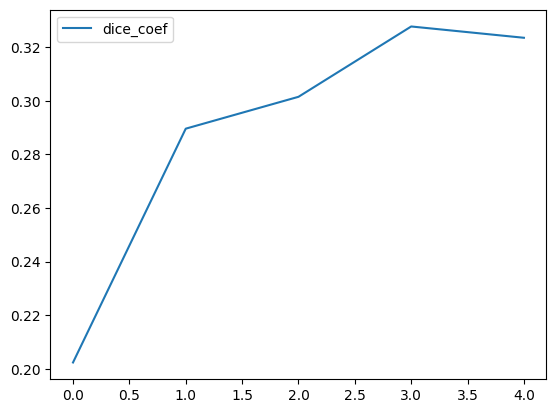

In [12]:
sns.lineplot(history['dice_coef'], label='dice_coef')


In [13]:
value = 5
result = model.predict(np.array([training[value]]))

1/1 [==============================] - 1s 561ms/step


In [14]:
def reassemble_image(quadrants):
    # Assuming quadrants is a list [top_left, top_right, bottom_left, bottom_right]
    top = np.concatenate((quadrants[0], quadrants[1]), axis=1)
    bottom = np.concatenate((quadrants[2], quadrants[3]), axis=1)
    full_image = np.concatenate((top, bottom), axis=0)
    return full_image


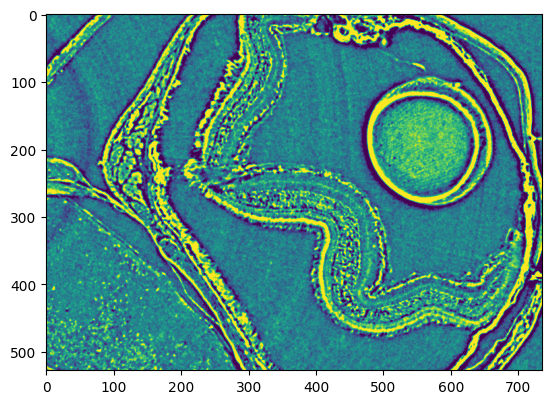

In [18]:
plt.imshow(training[value])

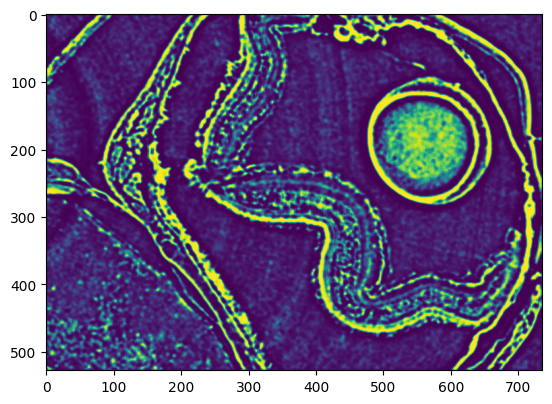

In [19]:
plt.imshow(np.squeeze(result))

# Recriando as imagens

In [92]:
resembled = reassemble_image(training[0:4])
resembled_target = reassemble_image(target[0:4])
resembled_predicted = {}
for i in range(4):
    array = np.array([training[i]])
    resembled_predicted[i] = np.array(model.predict(array))

1/1 [==============================] - 0s 12ms/step


In [97]:
resembled_predicted = reassemble_image([i[0] for i in resembled_predicted.values()])

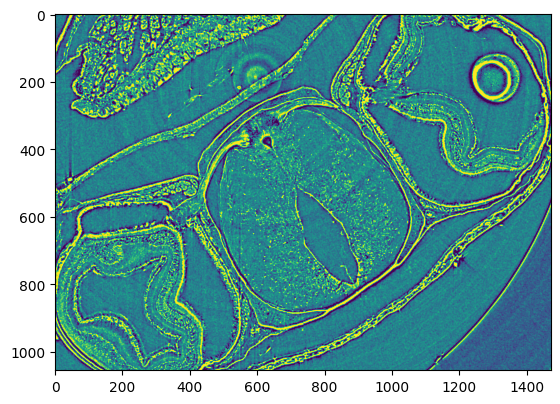

In [ ]:
plt.imshow(resembled)

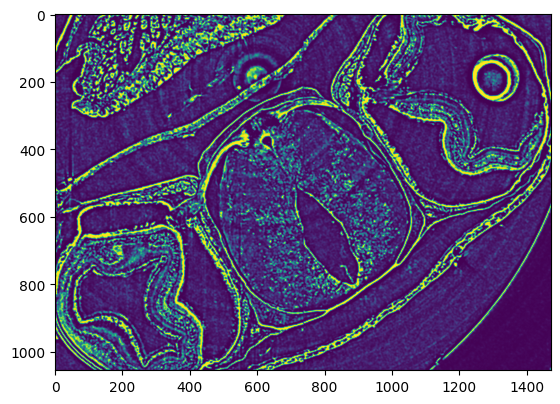

In [98]:
plt.imshow(resembled_predicted)

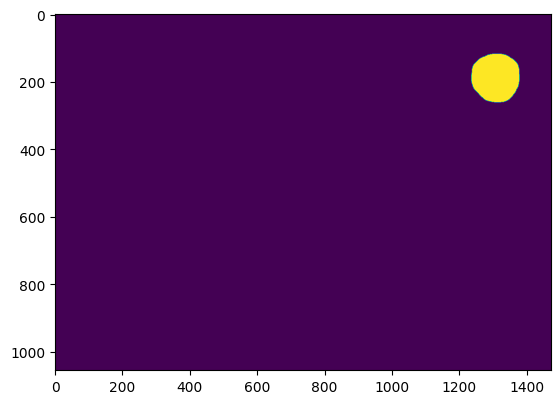

In [ ]:
plt.imshow(resembled_target)